Bengio's LM (2003):

**Input:** Dense Semantic Vectors of Size *d*, Context Window Size of *w*

**Ouput:** Probabilities of all Vocabs **V** Conditioned on Context Window *w*, i.e., Softmax

**Architecture:** X[1 * d], H[d * h], Y[1 * |V|]

**Formulation:** Y = Softmax(\sigma(\sigma(XW_I + B_I) W_O + B_O))

where W_I[d * h], B_I[1 * h], W_O[h * |V|], B_O[1 * |V|]



---------------------------------------------
1) Reading corpus and preprocess (tokenize, remove stopwords, ...)

In [9]:
import numpy as np
from itertools import chain
import pandas as pd

import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

gdrive = '/content/drive/MyDrive/Academic/UWindsor/Course/COMP8730_NLP/W2021_Hossein_Fani/Lectures/Lec05_Neural_Language_Models/Colab'
df = pd.read_csv(gdrive + '/reddit_worldnews.csv')
newsTitles = df["title"].values


stop_words = stopwords.words('english')

def preprocess(text):
     text = text.lower()  # To lower
     doc = word_tokenize(text)  # Tokenize to words
     doc = [word for word in doc if word not in stop_words]  # Remove stopwords.
     doc = [word for word in doc if word.isalpha()]  # Remove numbers and special characters
     return doc

news_preprocess = [preprocess(title) for title in newsTitles]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
print(len(news_preprocess))

509236


---------------------------------------------
2) Train Word2Vec to output dense semantic vectors of tokens

In [5]:
from gensim.models import Word2Vec, KeyedVectors

d = 100
w2v_w = 5 

#w2v = Word2Vec(news_preprocess, min_count=1, window=w2v_w, size=d, iter=100)
#w2v.save(f'{gdrive}/w2v_model_w{w2v_w}_d{d}')

gdrive = '/content/drive/MyDrive/Academic/UWindsor/Course/COMP8730_NLP/W2021_Hossein_Fani/Lectures/Lec05_Neural_Language_Models/Colab'
w2v = Word2Vec.load(f'{gdrive}/w2v_model_w{w2v_w}_d{d}')
w2v.init_sims(replace=True)
#sample output
word = 'king'
word_v = w2v.wv[word]
print(w2v.wv.most_similar([word_v]))

import numpy as np
for i, y in enumerate(w2v.wv.vocab):
  if i > 10: break
  print(f'({word}, {y}): {np.dot(np.linalg.norm(w2v.wv[word]), np.linalg.norm(w2v.wv[y]))}')



[('king', 0.9999999403953552), ('queen', 0.6703833937644958), ('prince', 0.6614470481872559), ('monarchy', 0.6195147037506104), ('princess', 0.6182918548583984), ('adulyadej', 0.5434785485267639), ('throne', 0.5145174264907837), ('milovanov', 0.506561815738678), ('assma', 0.5052620768547058), ('bhumibol', 0.5036876201629639)]
(king, scores): 0.9999997615814209
(king, killed): 0.9999999403953552
(king, pakistan): 0.9999999403953552
(king, clashes): 0.9999998807907104
(king, japan): 0.9999999403953552
(king, resumes): 0.9999999403953552
(king, refuelling): 0.9999999403953552
(king, mission): 0.9999998807907104
(king, us): 0.9999998807907104
(king, presses): 0.9999998807907104
(king, egypt): 0.9999998807907104


In [ ]:
#import gensim.downloader as api
#w2v = api.load('word2vec-google-news-300')

-------------
3A) Build the neural architecture

81234
[0.5]
[3.72007598e-44 5.00000000e-01 1.00000000e+00]
[0.26894142 0.73105858]
[1.38389653e-87 3.72007598e-44 1.00000000e+00]
(200, 10) (1, 10)
(10, 81234) (1, 81234)
[[1.78984593e-05 7.14953467e-06 7.25513646e-06 ... 1.51976631e-05
  1.81383595e-05 7.37795393e-06]]
[['scores', 'killed', 'pakistan', 'clashes'], ['japan', 'resumes', 'refuelling', 'mission'], ['us', 'presses', 'egypt', 'gaza', 'border'], ['economy', 'give', 'health', 'care'], ['council', 'europe', 'bashes', 'eu', 'un', 'terror', 'blacklist'], ['hay', 'presto', 'farmer', 'unveils', 'illegal', 'castle', 'tried', 'hide', 'behind', 'hay', 'bales'], ['strikes', 'protests', 'gridlock', 'border'], ['mismanagement', 'program'], ['nicolas', 'sarkozy', 'threatens', 'sue', 'ryanair'], ['us', 'plans', 'missile', 'shields', 'polish', 'town', 'met', 'resistance', 'video']]
['scores', 'killed'] => invaluable


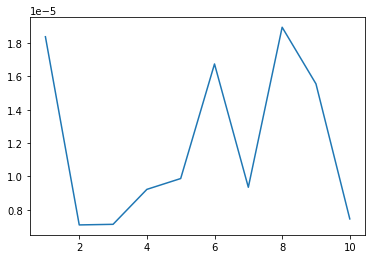

In [10]:
h = 10 #size of the hidden layer
V_size = len(w2v.wv.vocab) #size of the vocab (unique tokens)
lm_w = 2 # could be same from word2vec context window size w2v_w.

print(V_size)

def sigmoid(X): #our activation
  return 1 / (1 + np.exp(-X))

print(sigmoid(np.asarray([0.])))
print(sigmoid(np.asarray([-100., 0., 100.])))  

def softmax(X):
  return np.asarray([np.exp(x) / np.sum(np.exp(X)) for x in X])

print(softmax(np.asarray([0., 1.])))
print(softmax(np.asarray([-100., 0., 100.])))  

W_I = np.random.randn(lm_w * d, h)
B_I = np.random.randn(1, h)
print(W_I.shape, B_I.shape)

W_O = np.random.randn(h, V_size)
B_O = np.random.randn(1, V_size)
print(W_O.shape, B_O.shape)

def forward(X):
  H = sigmoid(np.matmul(X, W_I) + B_I)
  O = sigmoid(np.matmul(H, W_O) + B_O)
  Y = softmax(O)

  return Y
  #for backward grad!
  #X = sigmoid(np.mm(X, W_I) + B_I)
  #X = sigmoid(np.mm(X, W_O) + B_O)
  #X = softmax(X)

print(forward(np.random.randn(1, lm_w * d)))

#sample lm_w-gram
print(news_preprocess[:10])

flat_news_preprocess = [word for sentence in news_preprocess for word in sentence]

X = [w2v.wv[word] for word in flat_news_preprocess[:lm_w]]
X = np.asarray(X).flatten()

Y = forward(X)

from matplotlib import pyplot as plt
#plt.plot(range(1, V_size + 1), Y.transpose())
plt.plot(range(1, 11), Y.transpose()[:10])

next_word_index = np.argmax(Y)
print(f'{flat_news_preprocess[:lm_w]} => {w2v.wv.index2word[next_word_index]}')

3B) Build the neural architecture

In [15]:
from torch import nn
import torch.nn.functional as F

class MyBengioLM(nn.Module):
  def __init__(self, lm_w, d, h, V_size):
    super().__init__()

    self.lm_w = lm_w
    self.d = d
    self.h = h
    self.V_size = V_size
    
    self.W_I = nn.Linear(lm_w * d, h, bias=True)
    self.W_O = nn.Linear(h, V_size, bias=True)

  def forward(self, x):
    x = self.W_I(x)
    x = F.sigmoid(x)
    x = self.W_O(x)
    x = F.sigmoid(x)
    x = F.softmax(x, dim=1)
    return x

lm = MyBengioLM(lm_w=lm_w, d=d, h=h, V_size=V_size)
lm

MyBengioLM(
  (W_I): Linear(in_features=200, out_features=10, bias=True)
  (W_O): Linear(in_features=10, out_features=81234, bias=True)
)

In [13]:
class OriginalBengioLM(nn.Module):
  def __init__(self, lm_w, d, h, V_size):
    super().__init__()

    self.lm_w = lm_w
    self.d = d
    self.h = h
    self.V_size = V_size
    
    self.W_I = nn.Linear(lm_w * d, h, bias=True)
    self.W_O = nn.Linear(h, V_size, bias=True)

  def forward(self, x):
    x = self.W_I(x)
    x = torch.tanh(x)#x = F.sigmoid(x)
    x = self.W_O(x)
    #x = F.sigmoid(x)
    x = F.softmax(x, dim=1)
    return x

olm = OriginalBengioLM(lm_w=lm_w, d=d, h=h, V_size=V_size)
olm

OriginalBengioLM(
  (W_I): Linear(in_features=200, out_features=10, bias=True)
  (W_O): Linear(in_features=10, out_features=81234, bias=True)
)

3C) Train the neural architecture (One-Pass)

In [16]:
import torch 
BengioLM = nn.Sequential(nn.Linear(lm_w * d, h), 
                         nn.ReLU(),
                         nn.Linear(h, V_size))
                         #,nn.Softmax())#see below at nn.CrossEntropyLoss
print(BengioLM)

BengioLM_LogSoft = nn.Sequential(nn.Linear(lm_w * d, h), 
                         nn.ReLU(),
                         nn.Linear(h, V_size),
                         nn.LogSoftmax(dim=1))
print(BengioLM_LogSoft)

from nltk import ngrams
lm_w_grams = ngrams(flat_news_preprocess, lm_w + 1)

for grams in lm_w_grams:
  print(grams)
  context = [w2v.wv[word] for word in grams]
  
  #label: in our case, we have |V|-classifier and the class# is the index of word in the vocab
  y_index = w2v.wv.vocab[grams[-1]].index #the index of the true word

  #input
  X = np.asarray(context[:-1]).flatten()
  X = torch.from_numpy(X).view(1, lm_w * d)
  print(X.shape)
  
  #prediction
  Y_ = BengioLM(X)
  print(Y_.shape)
  #Loss functions like this usually takes the logit as parameter, rather than the post-softmax probability distributions. This is for numerical stability.
  #This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
  l = F.cross_entropy(Y_.view(1,V_size), torch.as_tensor([y_index]))
  print(l)
  
  Y_ = BengioLM_LogSoft(X)
  print(Y_.shape)
  l = F.nll_loss(Y_.view(1, V_size), torch.as_tensor([y_index]))
  print(l)
  
  Y_ = lm.forward(X)
  print(Y_.shape)
  l = F.nll_loss(Y_.view(1, V_size), torch.as_tensor([y_index]))
  print(l)
  
  Y_ = olm.forward(X)
  print(Y_.shape)
  l = F.nll_loss(Y_.view(1, V_size), torch.as_tensor([y_index]))
  print(l)
  
  break



Sequential(
  (0): Linear(in_features=200, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=81234, bias=True)
)
Sequential(
  (0): Linear(in_features=200, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=81234, bias=True)
  (3): LogSoftmax(dim=1)
)
('scores', 'killed', 'pakistan')
torch.Size([1, 200])
torch.Size([1, 81234])
tensor(11.4314, grad_fn=<NllLossBackward>)
torch.Size([1, 81234])
tensor(11.5135, grad_fn=<NllLossBackward>)
torch.Size([1, 81234])
tensor(-1.2086e-05, grad_fn=<NllLossBackward>)
torch.Size([1, 81234])
tensor(-8.7373e-06, grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


3C) Train the neural architecture (No Batch, Each Pass Update)


In [17]:
from torch import optim

BengioLM_LogSoft = nn.Sequential(nn.Linear(lm_w * d, h), 
                         nn.ReLU(),
                         nn.Linear(h, V_size),
                         nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()
optimizer = optim.SGD(BengioLM_LogSoft.parameters(), lr=0.01)

for i, grams in enumerate(lm_w_grams):
  optimizer.zero_grad()
  
  print(grams)
  context = [w2v.wv[word] for word in grams]
  y_index = w2v.wv.vocab[grams[-1]].index #the index of the true word
  X = np.asarray(context[:-1]).flatten()
  X = torch.from_numpy(X).view(1, lm_w * d)
  Y_ = BengioLM_LogSoft(X)
  l = loss(Y_.view(1,V_size), torch.as_tensor([y_index]))
  print(l)
  
  #print(BengioLM_LogSoft[0].weight.grad)
  l.backward()
  #print(BengioLM_LogSoft[0].weight.grad)
  optimizer.step()
  if i > 10: break

('killed', 'pakistan', 'clashes')
tensor(11.5355, grad_fn=<NllLossBackward>)
('pakistan', 'clashes', 'japan')
tensor(11.5659, grad_fn=<NllLossBackward>)
('clashes', 'japan', 'resumes')
tensor(11.1313, grad_fn=<NllLossBackward>)
('japan', 'resumes', 'refuelling')
tensor(11.1978, grad_fn=<NllLossBackward>)
('resumes', 'refuelling', 'mission')
tensor(11.1831, grad_fn=<NllLossBackward>)
('refuelling', 'mission', 'us')
tensor(11.1795, grad_fn=<NllLossBackward>)
('mission', 'us', 'presses')
tensor(11.3303, grad_fn=<NllLossBackward>)
('us', 'presses', 'egypt')
tensor(11.4288, grad_fn=<NllLossBackward>)
('presses', 'egypt', 'gaza')
tensor(11.0490, grad_fn=<NllLossBackward>)
('egypt', 'gaza', 'border')
tensor(11.5272, grad_fn=<NllLossBackward>)
('gaza', 'border', 'economy')
tensor(11.4719, grad_fn=<NllLossBackward>)
('border', 'economy', 'give')
tensor(11.3028, grad_fn=<NllLossBackward>)


3C) Train the neural architecture (Create Batches)

In [ ]:

#create batches
data = torch.empty(0, lm_w * d + 1)
print(data)
for i, grams in enumerate(lm_w_grams):
  context = [w2v.wv[word] for word in grams]
  y_index = w2v.wv.vocab[grams[-1]].index #the index of the true word
  
  
  X = torch.as_tensor(context[:-1]).view(1, lm_w * d)
  y = torch.as_tensor([y_index]).view(1,1)
  X_y = torch.cat((X, y), 1)
  data = torch.cat((X_y, data), 0)

  if i > 100000: break

from torch.utils.data import Dataset, DataLoader
class PrepareData(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(X=data[:, :-1], y=data[:, -1])
ds = DataLoader(ds, batch_size=100, shuffle=True)

#for (X, y) in ds:
#  print(X.shape, y.shape)

tensor([], size=(0, 201))


3C) Train the neural architecture (Pass through Batches)

In [ ]:
from torch import optim

BengioLM_LogSoft = nn.Sequential(nn.Linear(lm_w * d, h), 
                         nn.ReLU(),
                         nn.Linear(h, V_size),
                         nn.Softmax(dim=1))

loss = nn.NLLLoss()
optimizer = optim.SGD(BengioLM_LogSoft.parameters(), lr=0.01)
#Adam is better due to mumentum and dynamic lr!

epochs = 10
for e in range(epochs):
  running_loss = 0
  for X, y in ds:
    y = y.type(torch.LongTensor)#PyTorch won't accept a FloatTensor as categorical target
    #y = y.view(y.shape[0], 1)#1D target tensor expected, multi-target not supported
    
    optimizer.zero_grad()
    Y_ = BengioLM_LogSoft.forward(X)
    #print(Y_.shape, y.shape)
    l = loss(Y_, y)
    
    #print(BengioLM_LogSoft[0].weight.grad)
    l.backward()
    #print(BengioLM_LogSoft[0].weight.grad)
    optimizer.step()
    
    #print(l.item())
    running_loss += l.item()  

  print(running_loss/X.shape[0])
  


In [40]:
X, y = next(iter(ds))
with torch.no_grad():
  Y_ = BengioLM_LogSoft.forward(X[0].view(1,lm_w * d))

print(f'true word index: {y[0]}, prob: {Y_[0, int(y[0])]}')
print(f'predicted: {torch.argmax(Y_)}, prob: {torch.max(Y_)}')


torch.Size([1, 81234])
true word index: 1835.0, prob: 1.2686583431786858e-05
predicted: 18188, prob: 1.7714233763399534e-05


4) Evaluate the neural architecture

In [ ]:
#on valid batch
#turn of grad
#at each epoch
probs, labels = Y_.topk(1, dim=1)
labels == y
